In [144]:
from ete3 import Tree
import numpy as np
# data from https://www.synapse.org/#!Synapse:syn20821809
truth = Tree('data/benchmark/SubC2_train_REF/SubC2_train_0002_REF.nw', format=8)
#print(truth.get_ascii())

In [55]:
import string
chars = ['0']+list(string.ascii_uppercase)+['-']
char_mapping = dict(zip(chars,np.arange(0,len(chars))))

In [56]:
seqs = {}
seq_strings = open('data/benchmark/SubC2_train_TXT/SubC2_train_0002.txt').readlines()
seq_len = len(seq_strings[0].split()[1])
for seq in seq_strings:
    cell = seq.split()[0]
    string = seq.split()[1]
    seqs[cell] = [char_mapping[char] for char in list(string)]
base_states = np.array([0] * seq_len) #change for other situations

In [58]:
from simulation import simulate_lineage
import numpy as np
import sys
#sys.path.append('../lateral')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
# medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
# fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
# cassette_sites = slow_guides+medium_guides
# lineage, Q = simulate_lineage(cassette_sites=cassette_sites, num_init_cells=2, init_death_prob=0.1,
#                      init_repr_prob=0.75, cancer_prob=1e-3, tree_depth=10)

from conversion_utils import networkx_to_ete, get_ete_cm
# etetree = networkx_to_ete(lineage)
cm = get_ete_cm(etetree)
cm

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
name,,,,,,,,,,,,,,,,,,,,,
c_0204,1,0,0,4,6,0,2,1,2,0,...,1,0,1,1,1,27,27,2,1,0
c_0209,1,0,2,0,0,2,2,0,2,0,...,1,0,1,0,0,5,1,0,2,6
c_0214,1,0,0,2,0,0,0,0,0,3,...,27,27,27,27,2,0,0,0,0,4
c_0225,1,0,3,0,0,0,0,0,1,0,...,1,0,0,0,0,2,1,0,1,1
c_0194,1,5,0,1,4,0,0,1,0,1,...,0,0,9,0,0,1,0,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_0128,5,27,1,0,1,0,0,0,1,1,...,0,1,0,10,0,0,0,2,0,0
c_1004,1,1,9,0,0,0,0,3,1,0,...,0,0,0,4,0,0,2,0,2,2
c_1078,0,1,0,0,2,0,0,0,0,0,...,0,0,1,0,0,0,2,0,0,2


In [62]:
# true_names = cm.index
# new_names = np.arange(0, len(cm.index))
# cm.index = new_names
# cm

In [63]:
from scipy.optimize import minimize
from scipy.special import logsumexp
from numba import jit

def get_ancestors(lca, base_states):
    ancestors = [lca]
    for ancestor in ancestors:
        for i in range(len(ancestor)):
            if ancestor[i] != base_states[i]:
                new_ancestor = ancestor.copy()
                new_ancestor[i] = base_states[i]
                ancestors += [new_ancestor]
        ancestors = list(np.unique(np.array(ancestors), axis=0))
    
    return ancestors

from scipy.linalg import expm
def P(t,Q):
    return expm(Q*t)

from math import exp, log
def rates_to_prob(rates, t):
    logprob = 0
    for rate in rates:
        if rate<=0: logprob += -(-rate) * t
        else: logprob += log(1-exp(-rate * t))
    return logprob

#TODO: implement ancestor prior correctly
from scipy.special import logsumexp
def l(t, x, y, ancestors, Q, a_prior=None):
    #Pt = P(t,Q)
    logprob = 0
    OVERFLOW_DIST = 10000
    #print(t)
    lca = ancestors[0]
    logprobs = [np.zeros(len(ancestors))]
    for i, ancestor in enumerate(ancestors):
        prior_prob = a_prior[np.sum(lca!=ancestor)] if a_prior is not None else 1
        #print(t)
        x_logprob = rates_to_prob(Q[ancestor,x],t)
        y_logprob = rates_to_prob(Q[ancestor,y],t)
        #print(x_logprob+y_logprob)
        to_add = x_logprob+y_logprob+log(prior_prob)
        #print(to_add)
        logprobs[i]=to_add
    total_logprob = logsumexp(logprobs)
    #normalizer = min(logprobs)
    #logprobs -= normalizer
    #print(logprobs)
    return -total_logprob

def get_dist_est(Q, x, y, base_states, all_a=True, a_prior=None, upper=10):
    
    n_sites = len(x)
    lca = (x!=y) * base_states + (x==y) * x
    ancestors=[lca]
    if all_a: ancestors = get_ancestors(lca)
    
    return minimize(l, 0.0002, args=(x,y,ancestors,Q,a_prior), bounds=[(0.0001,upper)], options={'gtol':1e-05,'ftol':2e-09}).x[0]

In [66]:
from tqdm.notebook import tqdm
def get_dm(cm_np, Q, base_states, all_a = True, a_prior=None, upper=10):
    
    n_species = len(cm_np[:,0])
    dm = np.zeros((n_species,n_species))
    for x in tqdm(range(n_species), leave=False):
        for y in tqdm(range(x,n_species),leave=False):
            x_seq = cm_np[x,:]
            y_seq = cm_np[y,:]
            if x == y or (x_seq==y_seq).all():
                dm[x,y]=0
            else: dm[x,y]=get_dist_est(Q,x_seq,y_seq, base_states, all_a=all_a, upper=10)#dm[x,y]=1#
            dm[y,x]=dm[x,y]
            if(np.max(dm[x,:])>upper*0.95):
                print("WARNING: distance upper bound too tight")
    return dm

In [67]:
def get_dm_hamm(cm_np, base_states, reversible=False):
    
    n_species = len(cm_np[:,0])
    dm = np.zeros((n_species,n_species))
    for x in tqdm(range(n_species), leave=False):
        for y in range(x,n_species):
            x_seq = cm_np[x,:]
            y_seq = cm_np[y,:]
            if not reversible:
                lca = (x_seq!=y_seq) * base_states + (x_seq==y_seq) * x_seq
                dm[x,y] = sum(x_seq!=lca)+sum(y_seq!=lca)
            else:
                dm[x,y] = sum(x_seq!=y_seq)
            dm[y,x]=dm[x,y]
    return dm

In [73]:
def get_phylip_dm(dm, names):
#names = cm.index
    line1 = '%d' % len(names)
    lines = [line1]
    for name, row in zip(names, dm):
        line = ""
        line += str(name)
        line += '\t'
        line += ' '.join([str(dist) for dist in row])
        lines.append(line)
        #for value in row:
        #    dm_phylip += '\t%s' % value
    return '\n'.join(lines)

In [74]:
import os
import subprocess
def weighbor(pdm, names, seq_len):
    dm_phylip = get_phylip_dm(pdm, names)
    #print(dm_phylip)
    cmd = os.path.expanduser('~/phylogeny/Weighbor/weighbor')
    args = ('-L %i -b 300' % seq_len).split(' ') #todo: double-check Weighbor parameters
    proc = subprocess.run([cmd] + args,
                          input=dm_phylip.encode(),
                          stdout=subprocess.PIPE)
    newick = proc.stdout.decode().strip()
    #print(newick)
    return Tree(newick)

In [75]:
def est_Q(inferred_tree, cm_np, base_states):
    leaves = inferred_tree.get_leaves()
    n_leaves = len(leaves)
    for i, node in enumerate(leaves):
        #node = inferred_tree.get_leaves()[i]
        #print(node.name)
        node.cassette_state = cm_np[i,:]
        #print(node.cassette_state)
    num_states = np.max(cm_np)+1
    transition_counter = np.zeros((num_states,num_states))
    state_counter = np.zeros(num_states)
    #print(transition_counter)
    n_sites = None
    for node in inferred_tree.traverse("postorder"):
        if not hasattr(node,'cassette_state'):
            #todo: lca of multiple children
            x = node.children[0].cassette_state
            y = node.children[1].cassette_state
            n_sites = len(x)
            lca = (x!=y) * base_states + (x==y) * x
            node.cassette_state = lca
        n_sites = len(node.cassette_state)
        if len(node.children)>0:
            state_counter[node.cassette_state] += 1
        for child in node.children:
            for k in range(n_sites):
                from_state = node.cassette_state[k]
                to_state = child.cassette_state[k]
    #                 print(from_state,to_state)
                transition_counter[from_state,to_state] += 1
    
    EPSILON = 0.001
    Q_est = transition_counter/(state_counter[:,None]+EPSILON)
    np.fill_diagonal(Q_est,np.diag(Q_est)*-1)
    return Q_est

In [76]:
#estimate a prior over ancestors based on how many differences they have from the LCA
#for each pair of nodes in the inferred tree
def est_a_prior(tree):
    n_sites = len(tree.get_leaves()[0].cassette_state)
    a_prior = np.zeros(n_sites)
    for x in tree.get_leaves():
        for y in tree.get_leaves():
            x_seq = x.cassette_state
            y_seq = y.cassette_state
            #print('-------')
            lca = (x_seq!=y_seq) * np.arange(n_sites) + (x_seq==y_seq) * x_seq
            a_seq = tree.get_common_ancestor(x,y).cassette_state
            num_diffs = np.sum(lca!=a_seq)
            a_prior[num_diffs] += 1
    return a_prior/np.sum(a_prior)
            

In [109]:
Q_ests = []
trees = {'weighbor':[],'nj':[],'upgma':[]}
trees_hamm1 = {'weighbor':[],'nj':[],'upgma':[]}
trees_hamm2 = {'weighbor':[],'nj':[],'upgma':[]}
outputs = {'l':trees, 'hamm1':trees_hamm1, 'hamm2':trees_hamm2}
dms = []
def infer_tree(cm, Q=None):
    #true_names = cm.index
    #new_names = np.arange(0, len(cm.index))
    #cm.index = new_names
    #name_dict = dict(zip(new_names, true_names))
    
    #set initial rate matrix
    num_states = np.max(cm.to_numpy())+1
    num_sites = cm.to_numpy().shape[1]
    
    Q0 = np.zeros((len(chars),len(chars)))
    np.fill_diagonal(Q0,-1)
    Q0[np.unique(base_states),:] = 1
    #Q0[-1,-1]=1
    Q0[np.unique(base_states),np.unique(base_states)]= -1 * (len(chars)-len(np.unique(base_states)))
    Q0[:,-1]=1
    
    if Q is not None: Q0=Q
    
    Q_est = Q0
    Q_ests.append(Q_est)
    for i in tqdm(range(4)):
        
        #compute distance matrix
        
        print('computing distance matrix')
        cm_np = cm.to_numpy()
        dm = get_dm(cm_np, Q_est, base_states, all_a=False)
        dms.append(dm)
        
        dm_hamm1 = get_dm_hamm(cm_np, base_states)
        dm_hamm2 = get_dm_hamm(cm_np, base_states, reversible=True)
        dm_dict = {'l':dm, 'hamm1':dm_hamm1, 'hamm2':dm_hamm2}
        #TODO: add method from JC69?
        
        output = trees
        for dm_method in ['l','hamm1','hamm2']:
            dm = dm_dict[dm_method]
            output = outputs[dm_method]
            
            #infer using Weighbor
            print('using Weighbor to infer tree')
            names = cm.index
            inferred_tree = weighbor(dm, names, 6)
            output['weighbor'].append(inferred_tree)
            if dm_method == 'l':
                print('getting new estimate of Q')
                Q_est = est_Q(inferred_tree, cm_np, base_states)
                a_prior = est_a_prior(inferred_tree)
                Q_ests.append(Q_est)


            #infer using NJ and UPGMA
            names = [str(x) for x in cm.index]
            print('using NJ to infer tree')
            triangular = [list(dm[i,:i+1]) for i in range(dm.shape[0])]
            constructor = DistanceTreeConstructor()
            mat = _DistanceMatrix(names, triangular)
            tree = constructor.nj(mat)
            Phylo.write(tree, "tmp.txt", "newick")
            output['nj'].append(Tree('tmp.txt',format=1))
            print('using UPGMA to infer tree')
            tree = constructor.upgma(mat)
            Phylo.write(tree, "tmp.txt", "newick")
            output['upgma'].append(Tree('tmp.txt',format=1))
        
        #estimate Q and the prior on the ancestors


In [112]:
infer_tree(cm)

  0%|          | 0/4 [00:00<?, ?it/s]

computing distance matrix


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

using Weighbor to infer tree
getting new estimate of Q
using NJ to infer tree
using UPGMA to infer tree
using Weighbor to infer tree
using NJ to infer tree
using UPGMA to infer tree
using Weighbor to infer tree
using NJ to infer tree
using UPGMA to infer tree
computing distance matrix


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

using Weighbor to infer tree
getting new estimate of Q
using NJ to infer tree
using UPGMA to infer tree
using Weighbor to infer tree
using NJ to infer tree
using UPGMA to infer tree
using Weighbor to infer tree
using NJ to infer tree
using UPGMA to infer tree
computing distance matrix


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

using Weighbor to infer tree
getting new estimate of Q
using NJ to infer tree
using UPGMA to infer tree
using Weighbor to infer tree
using NJ to infer tree
using UPGMA to infer tree
using Weighbor to infer tree
using NJ to infer tree
using UPGMA to infer tree
computing distance matrix


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

using Weighbor to infer tree
getting new estimate of Q
using NJ to infer tree
using UPGMA to infer tree
using Weighbor to infer tree
using NJ to infer tree
using UPGMA to infer tree
using Weighbor to infer tree
using NJ to infer tree
using UPGMA to infer tree


In [113]:
np.max(Q_ests[2]-Q_ests[4])

0.0

In [115]:
#print(trees[0].get_ascii())
print(trees['weighbor'][1].get_ascii())
print(trees['nj'][1].get_ascii())
print(trees['upgma'][1].get_ascii())


               /-c_0765
            /-|
           |   \-c_0343
           |
         /-|      /-c_0795
        |  |   /-|
        |  |  |   \-c_0896
        |   \-|
        |     |   /-c_0791
      /-|      \-|
     |  |         \-c_0356
     |  |
     |  |   /-c_0363
     |  |  |
     |   \-|   /-c_0975
     |     |  |
     |     |  |         /-c_0215
     |      \-|      /-|
   /-|        |     |   \-c_0987
  |  |        |   /-|
  |  |        |  |  |   /-c_1048
  |  |         \-|   \-|
  |  |           |      \-c_1043
  |  |           |
  |  |            \-c_0969
  |  |
  |  |   /-c_0331
  |   \-|
  |     |   /-c_0167
  |      \-|
  |         \-c_0204
  |
  |         /-c_0779
  |      /-|
  |     |   \-c_0403
  |     |
  |     |         /-c_0267
  |   /-|      /-|
  |  |  |   /-|   \-c_0591
  |  |  |  |  |
  |  |  |  |   \-c_0271
  |  |   \-|
  |  |     |      /-c_0045
  |  |     |   /-|
  |  |     |  |  |   /-c_0191
  |  |      \-|   \-|
  |  |        |      \-c_0586
  |  |       

In [116]:
print(truth.get_ascii())


                        /-c_0204
                     /-|
                  /-|   \-c_0209
                 |  |
               /-|   \-c_0214
              |  |
            /-|   \-c_0225
           |  |
           |   \-c_0194
           |
           |            /-c_0586
         /-|         /-|
        |  |      /-|   \-c_0271
        |  |     |  |
        |  |   /-|   \-c_0591
        |  |  |  |
        |   \-|   \-c_0267
        |     |
        |      \-c_0233
        |
        |            /-c_0323
        |         /-|
        |        |   \-c_0331
      /-|      /-|
     |  |     |  |   /-c_0192
     |  |     |   \-|
     |  |   /-|     |   /-c_0594
     |  |  |  |      \-|
     |  |  |  |         \-c_0320
     |  |  |  |
     |  |  |   \-c_0304
     |  |  |
     |  |  |                  /-c_0356
     |  |  |               /-|
     |  |  |            /-|   \-c_0791
     |   \-|           |  |
     |     |         /-|   \-c_0896
     |     |        |  |
     |     |      /-|  

In [117]:
#todo: make own neighbor-joining algorithm
#todo: preprocess to merge identical nodes

In [140]:
temp = outputs['l']['weighbor'][3].copy()
temp.resolve_polytomy()
temp.compare(truth)['norm_rf']

0.7755102040816326

# Distance Matrix Comparison

In [121]:
dm_hamm1 = get_dm_hamm(cm_np,base_states)
dm_hamm2 = get_dm_hamm(cm_np,base_states,reversible=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

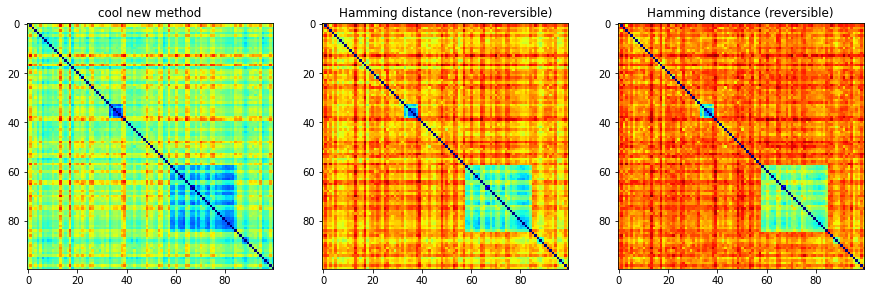

In [129]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(dms[1],cmap='jet',interpolation='nearest')
axs[0].set_title('cool new method')
axs[1].imshow(dm_hamm1,cmap='jet',interpolation='nearest')
axs[1].set_title('Hamming distance (non-reversible)')
axs[2].imshow(dm_hamm2,cmap='jet',interpolation='nearest')
axs[2].set_title('Hamming distance (reversible)')
plt.savefig('distance-comparison.png',dpi=400,bbox_inches='tight')
plt.show()

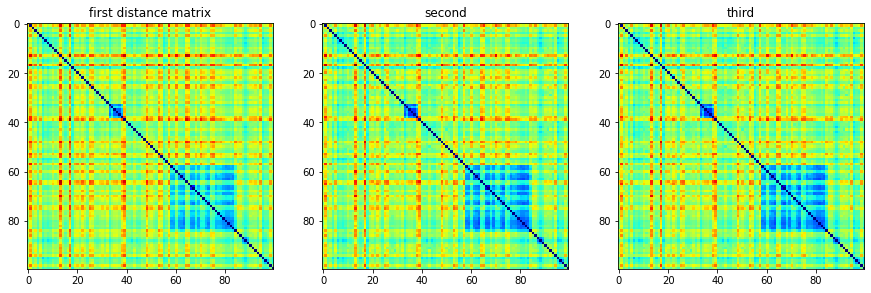

In [130]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(dms[0],cmap='jet',interpolation='nearest')
axs[0].set_title('first distance matrix')
axs[1].imshow(dms[1],cmap='jet',interpolation='nearest')
axs[1].set_title('second')
axs[2].imshow(dms[2],cmap='jet',interpolation='nearest')
axs[2].set_title('third')
plt.savefig('distance-comparison2.png',dpi=400,bbox_inches='tight')
plt.show()

(array([ 102.,    8.,  284.,  746., 3100., 3404., 1702.,  542.,   94.,
          18.]),
 array([0.        , 0.00050057, 0.00100114, 0.00150172, 0.00200229,
        0.00250286, 0.00300343, 0.00350401, 0.00400458, 0.00450515,
        0.00500572]),
 <BarContainer object of 10 artists>)

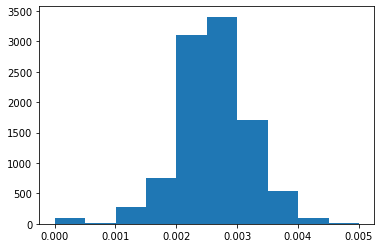

In [52]:
plt.hist(dms[1].flatten())

# Tree Comparison

In [139]:
from prettytable import PrettyTable
 
# Specify the Column Names while initializing the Table
table = PrettyTable(["algo", "EM", "hamm-NTR", "hamm-TR"]) 
for method in ['weighbor','nj','upgma']:
    row = [method]
    for dm_method in ['l','hamm1','hamm2']:
        temp = outputs[dm_method][method][1].copy()
        temp.resolve_polytomy()
        row.append(temp.compare(truth)['norm_rf'])
    table.add_row(row)
print(table)

+----------+--------------------+--------------------+--------------------+
|   algo   |         EM         |      hamm-NTR      |      hamm-TR       |
+----------+--------------------+--------------------+--------------------+
| weighbor | 0.7755102040816326 | 0.8979591836734694 | 0.8571428571428571 |
|    nj    | 0.7959183673469388 | 0.7755102040816326 | 0.8061224489795918 |
|  upgma   | 0.8469387755102041 | 0.8571428571428571 | 0.826530612244898  |
+----------+--------------------+--------------------+--------------------+


In [143]:
#download trees, should run analysis.R to check similarity
if not os.path.exists('output'): os.mkdir('output')
for method in ['weighbor','nj','upgma']:
    row = [method]
    for dm_method in ['l','hamm1','hamm2']:
        temp = outputs[dm_method][method][1].copy()
        temp.resolve_polytomy()
        temp.write(outfile='output/'+method+'-'+dm_method+'.txt')
        row.append(temp.compare(truth)['norm_rf'])